# Données et Variables

## 1. Source des données et construction des portefeuilles

### Source des données

Les données utilisées dans ce projet proviennent d’un fichier Excel construit manuellement à partir de données de marché publiques. Le fichier contient les prix historiques de différentes classes d’actifs représentatives d’un portefeuille diversifié.



In [34]:
import pandas as pd 
import numpy as np
from scipy import stats as st
import matplotlib.pyplot as plt
from pypfopt import risk_models, plotting
import seaborn as sns


excel = "data_pp.xlsx"

### Classes d'actifs considérées 

| Classe d’actif     | Proxy              |
| ------------------ | ------------------ |
| Actions            | S&P 500 Index      |
| Obligations        | Vanguard Total Bond Market ETF |
| Or                 | SPDR Gold Shares           |
| Cash               | State Street SPDR Bloomberg 1-3 Month T-Bill    |

Le portefeuille est composé de 4 grandes classes d'actifs : actions, obligations, or, cash afin de réfléter une allocation multi-actifs classique comme la représentation d'un portefeuille permanent. 

### Période et fréquence 

L’échantillon couvre la période allant de mai 2007 à février 2026 avec une fréquence daily, permettant de capturer plusieurs régimes de marché, incluant la crise financière de 2008, la crise sanitaire de 2020 et la période inflationniste récente. 

### Structure du fichier Excel 

Le fichier Excel est structuré de la manière suivante : chaque colonne correspond à une classe d’actifs et chaque ligne à une date d’observation.

In [35]:
df = pd.read_excel(excel,
                   parse_dates=True,
                   index_col=0,
                   header=0
                   )

In [36]:
df.head()

,bonds,stock,gold,cash
date,,,,
2007-04-30,75.49,1482.3673,67.09,91.74
2007-05-01,75.32,1486.3036,66.69,91.74
2007-05-02,75.33,1495.9183,66.66,91.74
2007-05-03,75.28,1502.3906,67.49,91.74
2007-05-04,75.34,1505.6170,68.19,91.74


In [37]:
df.tail()

,bonds,stock,gold,cash
date,,,,
2026-02-02,73.91,6976.444181,427.13,91.39
2026-02-03,73.93,6917.811704,454.29,91.39
2026-02-04,73.90,6882.721111,453.97,91.41
2026-02-05,74.22,6798.399477,441.88,91.41
2026-02-06,74.23,6932.297669,455.46,91.44


## 2. Variable et statistiques descriptives

### Rendements des classes d'actifs 

Les rendements quotidiens de chaque classe d'actifs sont calculés à partir des prix selon la formule suivante :

$$
R_{i,t} = ln(\frac {P_{i,t}} {P_{i,t-1}})
$$

Où :

$P_{i,t}$ est le prix de la classe d’actifs i à la date t ; 
$R_{i,t}$ est le rendement logarithmique

In [38]:
log_returns = np.log(df/df.shift(1)) 
log_returns = log_returns.dropna()

log_returns

,bonds,stock,gold,cash
date,,,,
2007-05-01,-0.002254,0.002652,-0.005980,0.000000
2007-05-02,0.000133,0.006448,-0.000450,0.000000
2007-05-03,-0.000664,0.004317,0.012374,0.000000
2007-05-04,0.000797,0.002145,0.010318,0.000000
2007-05-07,0.000663,0.002565,0.000880,0.000000
...,...,...,...,...
2026-02-02,-0.004320,0.005377,-0.040873,-0.002841
2026-02-03,0.000271,-0.008440,0.061647,0.000000
2026-02-04,-0.000406,-0.005085,-0.000705,0.000219


### Statistiques par classe d'actif

       Mean (daily)  Median (daily)  Volatility (daily)  Mean (annualized)  \
bonds -3.563043e-06        0.000124            0.003342          -0.000898   
stock  3.265349e-04        0.000721            0.012587           0.082287   
gold   4.054346e-04        0.000557            0.011237           0.102170   
cash  -6.933678e-07        0.000000            0.000494          -0.000175   

       Volatility (annualized)  Skewness   Kurtosis  
bonds                 0.053045 -0.641619  32.409229  
stock                 0.199818 -0.467378  12.377931  
gold                  0.178389 -0.414004   7.740474  
cash                  0.007834 -4.172652  36.421199  


,bonds,stock,gold,cash
date,,,,
2026-02-02,-0.020930,3.706286,5.366523,-0.003815
2026-02-03,-0.020665,3.666733,5.771352,-0.003815
2026-02-04,-0.021062,3.643061,5.766582,-0.003597
2026-02-05,-0.016823,3.586177,5.586377,-0.003597
2026-02-06,-0.016691,3.676505,5.788791,-0.003270


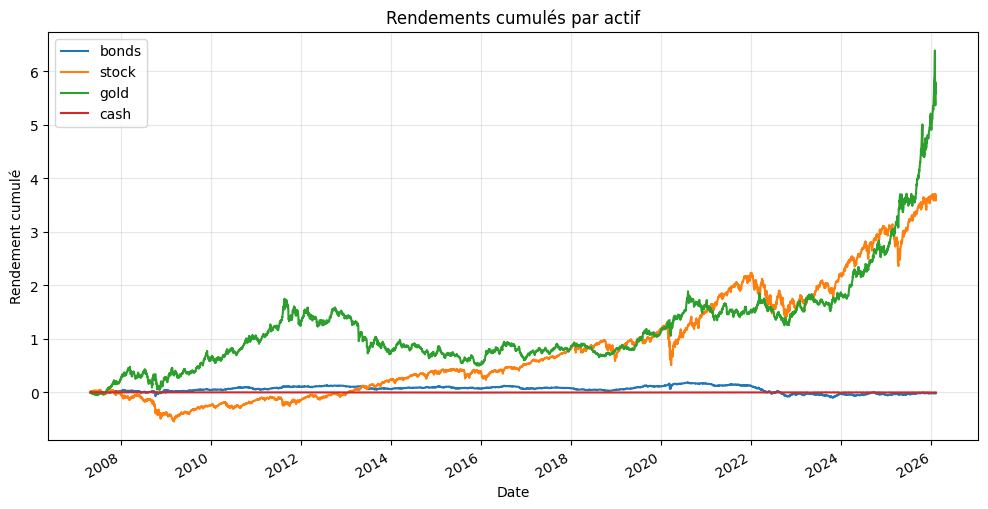

In [39]:
stats_returns = pd.DataFrame({
    "Mean (daily)": log_returns.mean(),
    "Median (daily)": log_returns.median(),
    "Volatility (daily)": log_returns.std(),
    "Mean (annualized)": log_returns.mean() * 252,
    "Volatility (annualized)": log_returns.std() * np.sqrt(252),
    "Skewness": log_returns.skew(),
    "Kurtosis": log_returns.kurtosis()
})
print(stats_returns)

# On peut aussi utiliser stats.describe pour illustrer les stats des différentes classes d'actifs
#stats = st.describe(log_returns)

# Cumul des rendements (jour par jour) pour chaque actif
cum_returns = np.exp(log_returns.cumsum()) - 1

# Affichage
display(cum_returns.tail())

# Graphique
ax = cum_returns.plot(figsize=(12, 6), title="Rendements cumulés par actif")
ax.set_xlabel("Date")
ax.set_ylabel("Rendement cumulé")
plt.grid(alpha=0.3)
plt.show()



Les actions et l'or présentent les rendements moyens les plus élevés mais également les volatilités les plus importantes. À l’inverse, les obligations et le cash offrent des profils plus défensifs confirmant leur rôle de stabilisateurs au sein d' un portefeuille.

### Distribution des rendements par classe d'actif 

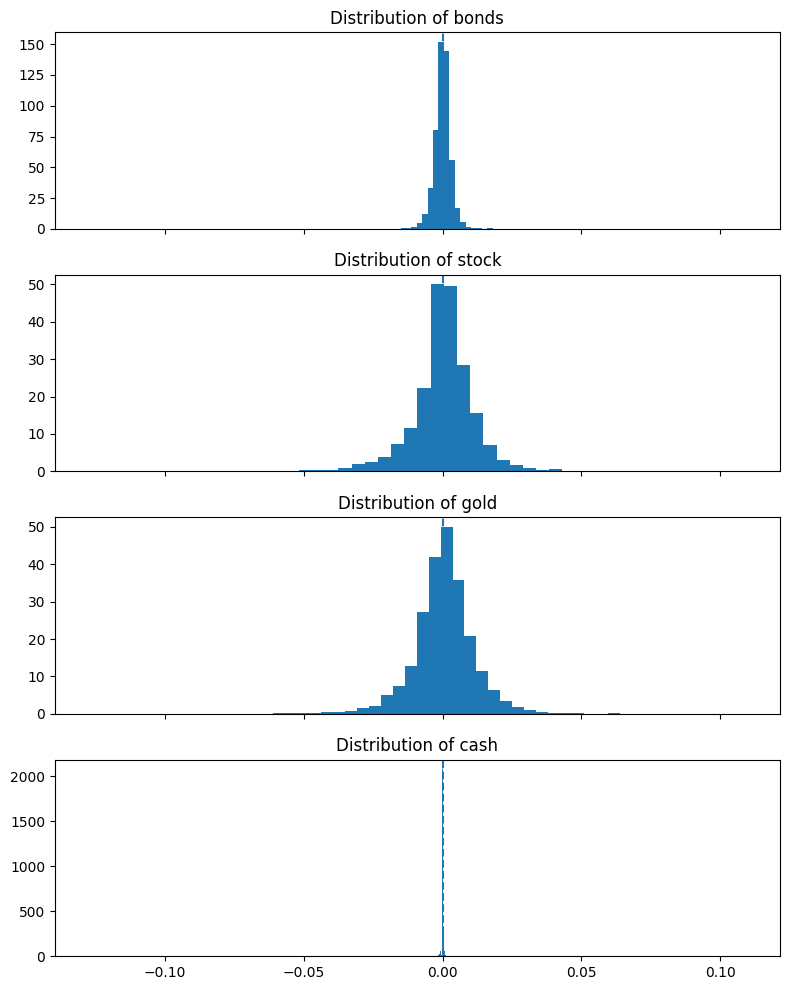

In [40]:

fig, axes = plt.subplots(
    nrows=len(log_returns.columns),
    ncols=1,
    figsize=(8, 2.5 * len(log_returns.columns)),
    sharex=True
)

for i, col in enumerate(log_returns.columns):
    axes[i].hist(log_returns[col].dropna(), bins=50, density=True)
    axes[i].set_title(f"Distribution of {col}")
    axes[i].axvline(0, linestyle="--")

plt.tight_layout()
plt.show()

Les graphiques de distribution des rendements illustrent la répartition des rendements par classe d'actifs. Les actions présentent la plus grande dispersion et des queues de distribution épaisses, tandis que les obligations et le cash affichent des distributions regroupées autour de zéro. L'or présente un profil intermédiaire, confirmant son rôle d'actif de diversification et de couverture.

### Matrice de covariance et corrélation 

,bonds,stock,gold,cash
bonds,1.000000,-0.026024,0.215229,0.060949
stock,-0.026024,1.000000,0.048679,-0.075112
gold,0.215229,0.048679,1.000000,0.005026
cash,0.060949,-0.075112,0.005026,1.000000


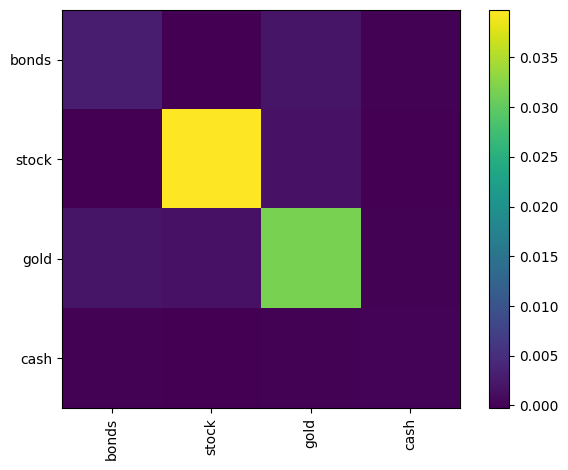

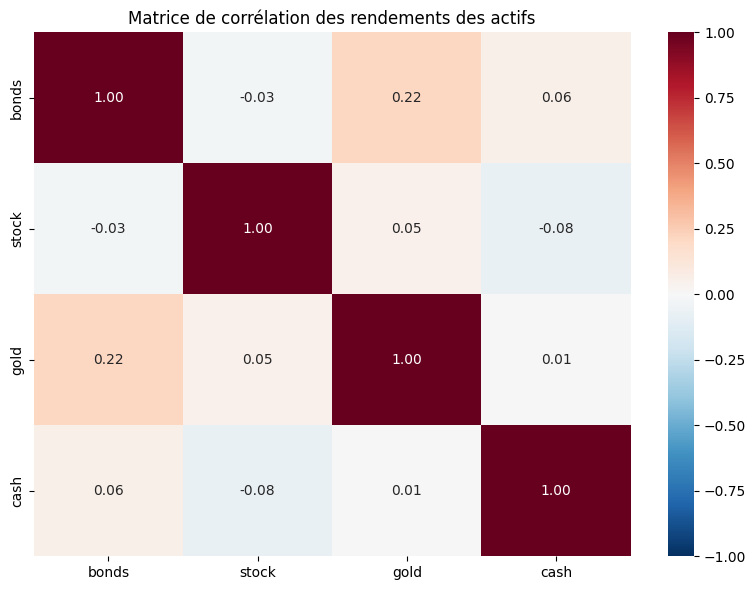

In [41]:

# Matrice de covariance entre les actifs 
cov_matrix = risk_models.risk_matrix(df)
plotting.plot_covariance(cov_matrix)

# Matrice de corrélation entre les actifs
corr_matrix = log_returns.corr()
display(corr_matrix)


plt.figure(figsize=(8, 6))
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap="RdBu_r",
    center=0,
    vmin=-1, vmax=1
)
plt.title("Matrice de corrélation des rendements des actifs")
plt.tight_layout()
plt.show()

On observe que les actions présentent la variance la plus élevée ce qui confirme leur caractère fortement volatil. Elles constituent donc la principale source de risque du portefeuille mais aussi son principal moteur de performance. L’or affiche également une variance significative bien que plus modérée que celle des actions traduisant un actif risqué mais de nature différente. Les obligations, quant à elles, présentent une volatilité plus faible cohérente avec leur rôle traditionnel d’actif défensif. Enfin, le cash se distingue par une variance quasi nulle, reflétant sa stabilité et l’absence presque totale de fluctuations de valeur.

D'après la matrice de corrélation des différents actifs, aucun actif est très fortement correlé. La corrélation entre les actifs tend a avoir aucune relation linéaire entre eux. Cependant l'or et les obligations sont faiblement corrélé a 0.22. 